# Statewide Bicycle Crash Analysis in North Carolina (2007-2018)

In [1]:
# Dependencies and Setup
#%matplotlib notebook
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from pprint import pprint

import requests
import json
import time
import gmaps
#from us import states
from config import gkey

In [2]:
# Read the csv file containing the Bicycle Crash data for North Carolina
input_file_path = "Resources/bicycle-crash-data-chapel-hill-region.csv"
crash_data = pd.read_csv(input_file_path, delimiter = ";")

# View the csv file containing the Bicycle Crash data for North Carolina
crash_data

# There are 11266 records in 55 columns

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdConditio,RdConfig,RdDefects,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone
0,"33.9437020597,-78.3493385901",Yes,70,70+,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No
1,"35.3217726,-79.0388423701",Yes,8,6-10,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,T-Intersection,Smooth Asphalt,Rural,50 - 55 MPH,Stop Sign,Clear,No
2,"35.77105009,-78.6073184803",Yes,13,11-15,No,No,Facing Traffic,A: Suspected Serious Injury,Travel Lane,Black,...,Dry,"Two-Way, Divided, Positive Median Barrier",None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Cloudy,No
3,"35.9394515202,-77.7953706304",Yes,52,50-59,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Black,...,Dry,"One-Way, Not Divided",None,Four-Way Intersection,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
4,"36.0927628197,-80.2653764398",Yes,27,25-29,No,No,Not Applicable,C: Possible Injury,Non-Roadway,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11261,"34.2546581498,-77.9197554903",Yes,26,25-29,No,No,Facing Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
11262,"35.2123611203,-80.7913412696",Yes,20,20-24,No,No,Facing Traffic,C: Possible Injury,Sidewalk / Crosswalk / Driveway Crossing,Black,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,No Control Present,Cloudy,No
11263,"35.64331907,-80.4828223001",Yes,11,11-15,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Unknown/Missing,...,Dry,"Two-Way, Divided, Unprotected Median",None,No Special Feature,Smooth Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No
11264,"34.1935523204,-77.9356315301",No,60,60-69,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No


### Cleaning the Crash Group data

In [3]:
# Clear rows with missing data in any column
clean_crash_data = crash_data.dropna(how='any')
clean_crash_data
# None of the records were deleted so none of the rows have missing data

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdConditio,RdConfig,RdDefects,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone
0,"33.9437020597,-78.3493385901",Yes,70,70+,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No
1,"35.3217726,-79.0388423701",Yes,8,6-10,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,T-Intersection,Smooth Asphalt,Rural,50 - 55 MPH,Stop Sign,Clear,No
2,"35.77105009,-78.6073184803",Yes,13,11-15,No,No,Facing Traffic,A: Suspected Serious Injury,Travel Lane,Black,...,Dry,"Two-Way, Divided, Positive Median Barrier",None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Cloudy,No
3,"35.9394515202,-77.7953706304",Yes,52,50-59,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Black,...,Dry,"One-Way, Not Divided",None,Four-Way Intersection,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
4,"36.0927628197,-80.2653764398",Yes,27,25-29,No,No,Not Applicable,C: Possible Injury,Non-Roadway,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11261,"34.2546581498,-77.9197554903",Yes,26,25-29,No,No,Facing Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
11262,"35.2123611203,-80.7913412696",Yes,20,20-24,No,No,Facing Traffic,C: Possible Injury,Sidewalk / Crosswalk / Driveway Crossing,Black,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,No Control Present,Cloudy,No
11263,"35.64331907,-80.4828223001",Yes,11,11-15,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Unknown/Missing,...,Dry,"Two-Way, Divided, Unprotected Median",None,No Special Feature,Smooth Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No
11264,"34.1935523204,-77.9356315301",No,60,60-69,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No


In [4]:
# Crashes by Crash Gpr
crashes_by_crashgrp = crash_data.groupby(["CrashGrp"])["geo_point_2d"].count()
crashes_by_crashgrp

# Needs cleaning

CrashGrp
Backing Vehicle                                               88
Bicyclist Failed to Yield - Midblock                         689
Bicyclist Failed to Yield - Sign-Controlled Intersection     642
Bicyclist Failed to Yield - Signalized Intersection          478
Bicyclist Failed to Yield—Midblock                            50
Bicyclist Failed to Yield—Sign-Controlled Intersection        37
Bicyclist Failed to Yield—Signalized Intersection             52
Bicyclist Left Turn / Merge                                  461
Bicyclist Left Turn/Merge                                     42
Bicyclist Overtaking Motorist                                232
Bicyclist Right Turn / Merge                                 128
Bicyclist Right Turn/Merge                                     6
Crossing Paths - Other Circumstances                         616
Crossing Paths—Other Circumstances                            58
Head-On                                                      300
Loss of Control 

In [5]:
# Cleaning Crash Group
crash_data["CrashGrp"] = crash_data["CrashGrp"].replace(
    {"Bicyclist Failed to Yield—Midblock": "Bicyclist Failed to Yield - Midblock",
    "Bicyclist Failed to Yield—Sign-Controlled Intersection": "Bicyclist Failed to Yield - Sign-Controlled Intersection",
    "Bicyclist Failed to Yield—Signalized Intersection": "Bicyclist Failed to Yield - Signalized Intersection",
    "Bicyclist Left Turn/Merge": "Bicyclist Left Turn / Merge",
    "Bicyclist Right Turn/Merge": "Bicyclist Right Turn / Merge",
    "Crossing Paths—Other Circumstances": "Crossing Paths - Other Circumstances",
    "Loss of Control/Turning Error": "Loss of Control / Turning Error",
    "Motorist Failed to Yield—Midblock": "Motorist Failed to Yield - Midblock",
    "Motorist Failed to Yield—Sign-Controlled Intersection": "Motorist Failed to Yield - Sign-Controlled Intersection",
    "Motorist Failed to Yield—Signalized Intersection": "Motorist Failed to Yield - Signalized Intersection",
    "Motorist Left Turn/Merge": "Motorist Left Turn / Merge",
     "Motorist Right Turn/Merge": "Motorist Right Turn / Merge",
     "Nonroadway": "Non-Roadway",
     "Other/Unknown—Insufficient Details": "Other / Unknown - Insufficient Details",
     "Other/Unusual Circumstances": "Other / Unusual Circumstances",
     "Parallel Paths—Other Circumstances": "Parallel Paths - Other Circumstances"
    })

In [6]:
# Check if all values were replaced correctly
# Crashes by Crash Gpr
crashes_by_crashgrp = crash_data.groupby(["CrashGrp"])["geo_point_2d"].count()
crashes_by_crashgrp.sort_values(ascending=False)

CrashGrp
Motorist Overtaking Bicyclist                               2207
Motorist Failed to Yield - Sign-Controlled Intersection     1073
Motorist Left Turn / Merge                                   978
Motorist Failed to Yield - Midblock                          824
Bicyclist Failed to Yield - Midblock                         739
Bicyclist Failed to Yield - Sign-Controlled Intersection     679
Crossing Paths - Other Circumstances                         674
Motorist Right Turn / Merge                                  585
Bicyclist Failed to Yield - Signalized Intersection          530
Non-Roadway                                                  503
Bicyclist Left Turn / Merge                                  503
Loss of Control / Turning Error                              477
Motorist Failed to Yield - Signalized Intersection           373
Head-On                                                      300
Bicyclist Overtaking Motorist                                232
Parallel Paths -

## Crash Latitude & Longitude Identification

In [7]:
# Added 2 columns for latitude and longitude by splitting the "geo_point_2d" column for use in mapping
# Adding two new columns to the existing dataframe. 
# bydefault splitting is done on the basis of single space. 
crash_data[["Crash Latitude","Crash Longitude"]] = crash_data["geo_point_2d"].str.split(',',expand=True) 
crash_data.head()

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdDefects,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,Crash Latitude,Crash Longitude
0,"33.9437020597,-78.3493385901",Yes,70,70+,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,None,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No,33.9437020597,-78.3493385901
1,"35.3217726,-79.0388423701",Yes,8,6-10,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,None,T-Intersection,Smooth Asphalt,Rural,50 - 55 MPH,Stop Sign,Clear,No,35.3217726,-79.0388423701
2,"35.77105009,-78.6073184803",Yes,13,11-15,No,No,Facing Traffic,A: Suspected Serious Injury,Travel Lane,Black,...,None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Cloudy,No,35.77105009,-78.6073184803
3,"35.9394515202,-77.7953706304",Yes,52,50-59,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Black,...,None,Four-Way Intersection,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No,35.9394515202,-77.7953706304
4,"36.0927628197,-80.2653764398",Yes,27,25-29,No,No,Not Applicable,C: Possible Injury,Non-Roadway,White,...,None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No,36.0927628197,-80.2653764398


## Time of Day Grouping

In [8]:
# Add a new column for Time of Day analysis
# Create bins for Time of Day
time_bins = [0, 6, 12, 18, 20, 24]
time_group_names = ["Early Morning (12-6am)", "Morning (6am-12pm)", "Afternoon (12-4pm)", "Evening (4-8pm)", "Night (8pm-12am)"]

# Categorize crashes using time bins using pd.cut() and add new column for time of day
crash_data["Time of Day"] = pd.cut(crash_data["CrashHour"], time_bins, include_lowest = False, labels=time_group_names)
crash_data

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,Crash Latitude,Crash Longitude,Time of Day
0,"33.9437020597,-78.3493385901",Yes,70,70+,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No,33.9437020597,-78.3493385901,Morning (6am-12pm)
1,"35.3217726,-79.0388423701",Yes,8,6-10,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,T-Intersection,Smooth Asphalt,Rural,50 - 55 MPH,Stop Sign,Clear,No,35.3217726,-79.0388423701,Afternoon (12-4pm)
2,"35.77105009,-78.6073184803",Yes,13,11-15,No,No,Facing Traffic,A: Suspected Serious Injury,Travel Lane,Black,...,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Cloudy,No,35.77105009,-78.6073184803,Afternoon (12-4pm)
3,"35.9394515202,-77.7953706304",Yes,52,50-59,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Black,...,Four-Way Intersection,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No,35.9394515202,-77.7953706304,Morning (6am-12pm)
4,"36.0927628197,-80.2653764398",Yes,27,25-29,No,No,Not Applicable,C: Possible Injury,Non-Roadway,White,...,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No,36.0927628197,-80.2653764398,Afternoon (12-4pm)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11261,"34.2546581498,-77.9197554903",Yes,26,25-29,No,No,Facing Traffic,C: Possible Injury,Travel Lane,White,...,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No,34.2546581498,-77.9197554903,Morning (6am-12pm)
11262,"35.2123611203,-80.7913412696",Yes,20,20-24,No,No,Facing Traffic,C: Possible Injury,Sidewalk / Crosswalk / Driveway Crossing,Black,...,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,No Control Present,Cloudy,No,35.2123611203,-80.7913412696,Afternoon (12-4pm)
11263,"35.64331907,-80.4828223001",Yes,11,11-15,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Unknown/Missing,...,No Special Feature,Smooth Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No,35.64331907,-80.4828223001,Afternoon (12-4pm)
11264,"34.1935523204,-77.9356315301",No,60,60-69,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,No Special Feature,Coarse Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No,34.1935523204,-77.9356315301,Night (8pm-12am)


In [9]:
unique_values = crash_data["Time of Day"].unique()
unique_values

[Morning (6am-12pm), Afternoon (12-4pm), Evening (4-8pm), NaN, Night (8pm-12am), Early Morning (12-6am)]
Categories (5, object): [Early Morning (12-6am) < Morning (6am-12pm) < Afternoon (12-4pm) < Evening (4-8pm) < Night (8pm-12am)]

In [10]:
checknan = crash_data[crash_data["Time of Day"] == "NaN"]
checknan

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,Crash Latitude,Crash Longitude,Time of Day


## Bikers Age Grouping (>50 years)

In [11]:
# Number of cities included in the study
total_crash_count = crash_data["geo_point_2d"].count()
county_count = crash_data["County"].nunique()
city_count = crash_data["City"].nunique()


print(f"Total number of Bicycle Crashes in North Carolina (2007-2018) = {total_crash_count}")
print (f"Number of Counties included in the study: {county_count}")
print (f"Number of Cities included in the study: {city_count}")

Total number of Bicycle Crashes in North Carolina (2007-2018) = 11266
Number of Counties included in the study: 100
Number of Cities included in the study: 327


In [12]:
# # Convert age columns to integers
# crash_data[["BikeAge", "DrvrAge"]] = crash_data[["BikeAge", "DrvrAge"]].apply(pd.to_numeric)
# crash_data.dtypes
# Unable to parse string 70+

## Basic Analysis

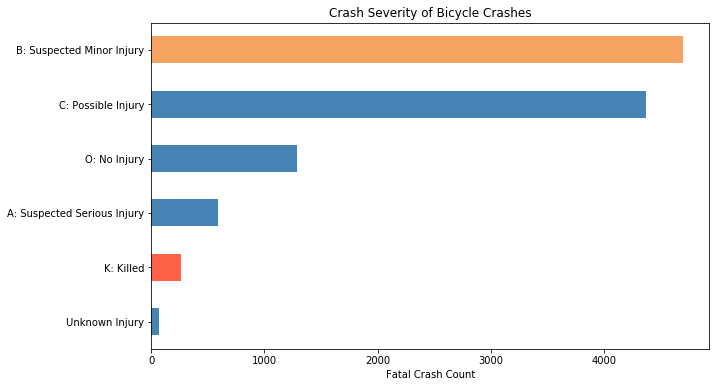

,Fatal Crash Count,Percent(%)
CrashSevr,,
B: Suspected Minor Injury,4696,41.68
C: Possible Injury,4369,38.78
O: No Injury,1283,11.39
A: Suspected Serious Injury,589,5.23
K: Killed,259,2.30
Unknown Injury,70,0.62


In [17]:
# Study crash severity
crash_severity = crash_data.groupby(["CrashSevr"])["geo_point_2d"].count()
crash_severity

crash_severity_df = pd.DataFrame(crash_severity)
crash_severity_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)

for row in range(len(crash_severity_df)):
    crash_severity_df["Percent(%)"] = round((crash_severity_df["Fatal Crash Count"] / total_crash_count)*100, 2) 

crash_severity_df = crash_severity_df.sort_values(by="Fatal Crash Count", ascending=True)

# Create a bar plot for distribution of fatal crashes by day of week
colors = ['steelblue', 'tomato', 'steelblue', 'steelblue', 'steelblue', 'sandybrown']
ax = crash_severity_df.plot(kind='barh', y = "Fatal Crash Count", color=colors, 
                                  figsize = (10,6), subplots = True, rot=0, legend=None)

plt.title("Crash Severity of Bicycle Crashes")
plt.ylabel("")
plt.xlabel("Fatal Crash Count")

# Save the bar plot for crash severity
plt.savefig("Output/CrashSeverity.png")

# Display the bar plot for crash severity
plt.show()

crash_severity_df.sort_values(by="Fatal Crash Count", ascending=False)

In [18]:
# Identify crashes where Bicyclist was killed
biker_killed = crash_data.loc[crash_data["BikeInjury"] == "K: Killed" ,:]
biker_killed

# 250 crashes resulted in biker being killed

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,Crash Latitude,Crash Longitude,Time of Day
51,"35.2467159998,-81.4257199999",Yes,46,40-49,.,No,With Traffic,K: Killed,Bike Lane / Paved Shoulder,White,...,No Special Feature,Smooth Asphalt,Rural,60 - 75 MPH,No Control Present,Clear,No,35.2467159998,-81.4257199999,Morning (6am-12pm)
71,"36.294113,-78.5467199997",Yes,45,40-49,.,No,With Traffic,K: Killed,Travel Lane,Black,...,No Special Feature,Smooth Asphalt,Rural,20 - 25 MPH,No Control Present,Rain,No,36.294113,-78.5467199997,Night (8pm-12am)
128,"34.1079300003,-77.9219800001",Yes,45,40-49,.,No,With Traffic,K: Killed,Bike Lane / Paved Shoulder,White,...,Other,Coarse Asphalt,Rural,50 - 55 MPH,Other,Clear,No,34.1079300003,-77.9219800001,Afternoon (12-4pm)
153,"35.7214929998,-78.8649700004",Yes,51,50-59,.,No,With Traffic,K: Killed,Travel Lane,White,...,T-Intersection,Grooved Concrete,Urban,40 - 45 MPH,No Control Present,Clear,No,35.7214929998,-78.8649700004,Morning (6am-12pm)
183,"36.2290972498,-79.2963211904",Yes,54,50-59,"Yes-Alcohol, impairment detected",Yes,With Traffic,K: Killed,Travel Lane,Black,...,Missing,Smooth Asphalt,Rural,50 - 55 MPH,No Control Present,"Fog, Smog, Smoke",No,36.2290972498,-79.2963211904,Night (8pm-12am)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11088,"35.8762974499,-78.5397780605",Yes,49,40-49,No,No,With Traffic,K: Killed,Travel Lane,White,...,No Special Feature,Smooth Asphalt,Urban,50 - 55 MPH,No Control Present,Clear,No,35.8762974499,-78.5397780605,Afternoon (12-4pm)
11125,"36.4367982501,-77.8760720501",Yes,58,50-59,"Yes-Alcohol, impairment suspected",Yes,Unknown,K: Killed,Travel Lane,Black,...,No Special Feature,Smooth Asphalt,Rural,50 - 55 MPH,"Double Yellow Line, No Passing Zone",Cloudy,No,36.4367982501,-77.8760720501,Night (8pm-12am)
11249,"36.4202171301,-77.1077045204",Yes,21,20-24,"Yes-Alcohol, impairment suspected",Yes,With Traffic,K: Killed,Travel Lane,Black,...,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,"Double Yellow Line, No Passing Zone",Clear,No,36.4202171301,-77.1077045204,Night (8pm-12am)
11254,"34.9021944702,-79.0741062998",Yes,54,50-59,"Yes-Alcohol, impairment suspected",Yes,With Traffic,K: Killed,Travel Lane,White,...,No Special Feature,Coarse Asphalt,Rural,50 - 55 MPH,"Double Yellow Line, No Passing Zone",Clear,No,34.9021944702,-79.0741062998,Night (8pm-12am)


In [19]:
# Identify crashes where the motorist was killed
motorist_killed = crash_data.loc[crash_data["DrvrInjury"] == "K: Killed",:]
motorist_killed
# 2 motorists were killed

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,Crash Latitude,Crash Longitude,Time of Day
3960,"36.3075390601,-80.7165385698",Yes,14,11-15,No,No,Unknown,B: Suspected Minor Injury,Other,White,...,No Special Feature,Smooth Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No,36.3075390601,-80.7165385698,Afternoon (12-4pm)
6251,"34.8811399996,-77.9744399999",Yes,37,30-39,.,No,With Traffic,B: Suspected Minor Injury,Travel Lane,Black,...,No Special Feature,Coarse Asphalt,Rural,Unknown,No Control Present,Clear,No,34.8811399996,-77.9744399999,Night (8pm-12am)


In [20]:
# Filter crashes that have resulted in fatalities 
#total_killed = crash_data.loc[(crash_data["BikeInjury"] == "K: Killed") | (crash_data["DrvrInjury"] == "K: Killed"),:]
total_killed = crash_data.loc[(crash_data["CrashSevr"] == "K: Killed"),:]
total_killed


,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,Crash Latitude,Crash Longitude,Time of Day
51,"35.2467159998,-81.4257199999",Yes,46,40-49,.,No,With Traffic,K: Killed,Bike Lane / Paved Shoulder,White,...,No Special Feature,Smooth Asphalt,Rural,60 - 75 MPH,No Control Present,Clear,No,35.2467159998,-81.4257199999,Morning (6am-12pm)
71,"36.294113,-78.5467199997",Yes,45,40-49,.,No,With Traffic,K: Killed,Travel Lane,Black,...,No Special Feature,Smooth Asphalt,Rural,20 - 25 MPH,No Control Present,Rain,No,36.294113,-78.5467199997,Night (8pm-12am)
128,"34.1079300003,-77.9219800001",Yes,45,40-49,.,No,With Traffic,K: Killed,Bike Lane / Paved Shoulder,White,...,Other,Coarse Asphalt,Rural,50 - 55 MPH,Other,Clear,No,34.1079300003,-77.9219800001,Afternoon (12-4pm)
153,"35.7214929998,-78.8649700004",Yes,51,50-59,.,No,With Traffic,K: Killed,Travel Lane,White,...,T-Intersection,Grooved Concrete,Urban,40 - 45 MPH,No Control Present,Clear,No,35.7214929998,-78.8649700004,Morning (6am-12pm)
183,"36.2290972498,-79.2963211904",Yes,54,50-59,"Yes-Alcohol, impairment detected",Yes,With Traffic,K: Killed,Travel Lane,Black,...,Missing,Smooth Asphalt,Rural,50 - 55 MPH,No Control Present,"Fog, Smog, Smoke",No,36.2290972498,-79.2963211904,Night (8pm-12am)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11088,"35.8762974499,-78.5397780605",Yes,49,40-49,No,No,With Traffic,K: Killed,Travel Lane,White,...,No Special Feature,Smooth Asphalt,Urban,50 - 55 MPH,No Control Present,Clear,No,35.8762974499,-78.5397780605,Afternoon (12-4pm)
11125,"36.4367982501,-77.8760720501",Yes,58,50-59,"Yes-Alcohol, impairment suspected",Yes,Unknown,K: Killed,Travel Lane,Black,...,No Special Feature,Smooth Asphalt,Rural,50 - 55 MPH,"Double Yellow Line, No Passing Zone",Cloudy,No,36.4367982501,-77.8760720501,Night (8pm-12am)
11249,"36.4202171301,-77.1077045204",Yes,21,20-24,"Yes-Alcohol, impairment suspected",Yes,With Traffic,K: Killed,Travel Lane,Black,...,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,"Double Yellow Line, No Passing Zone",Clear,No,36.4202171301,-77.1077045204,Night (8pm-12am)
11254,"34.9021944702,-79.0741062998",Yes,54,50-59,"Yes-Alcohol, impairment suspected",Yes,With Traffic,K: Killed,Travel Lane,White,...,No Special Feature,Coarse Asphalt,Rural,50 - 55 MPH,"Double Yellow Line, No Passing Zone",Clear,No,34.9021944702,-79.0741062998,Night (8pm-12am)


## Biker Fatality Analysis

In [21]:
# Identify count of total fatalities
total_fatalities = round(total_killed["geo_point_2d"].count(), 2)
print(f"Total Fatalities = {total_fatalities}")

Total Fatalities = 259


Average Fatal Crashes per Year (2007-2018): 21.58


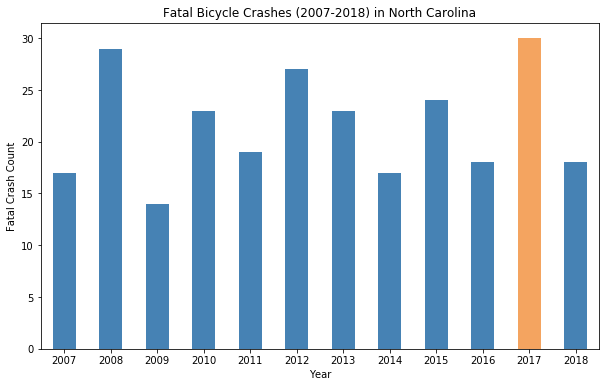

,Fatal Crash Count,Percent(%)
CrashYear,,
2017,30,11.58
2008,29,11.20
2012,27,10.42
2015,24,9.27
2010,23,8.88


In [22]:
# Fatal Crash count grouped by Crash year
total_killed_by_year = total_killed.groupby(["CrashYear"])["geo_point_2d"].count()
# biker_killed_by_year

total_killed_by_year_df = pd.DataFrame(total_killed_by_year)
total_killed_by_year_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)


mean_total_killed_by_year = round(total_killed_by_year_df["Fatal Crash Count"].mean(), 2)

total_killed_by_year_df["Percent(%)"] = ""

for row in range(len(total_killed_by_year_df)):
    total_killed_by_year_df["Percent(%)"] = round((total_killed_by_year_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
print(f"Average Fatal Crashes per Year (2007-2018): {mean_total_killed_by_year}")

# Create a bar plot for fatal crashes over time
colors = ['steelblue', 'steelblue', 'steelblue', 'steelblue', 'steelblue', 'steelblue', 
          'steelblue', 'steelblue', 'steelblue', 'steelblue', 'sandybrown', 'steelblue']
ax = total_killed_by_year_df.plot(kind='bar', y = "Fatal Crash Count", color=colors, 
                                  figsize = (10,6), subplots = True, rot=0, legend=None)

plt.title("Fatal Bicycle Crashes (2007-2018) in North Carolina")
plt.xlabel("Year")
plt.ylabel("Fatal Crash Count")

# Save the bar plot for crashes over time
plt.savefig("Output/KilledOverTime.png")

# Display the bar plot for crashes over time
plt.show()

total_killed_by_year_df.sort_values(by="Fatal Crash Count", ascending=False).head()

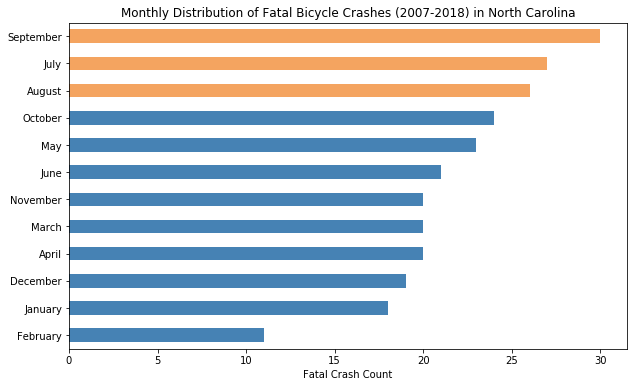

,Fatal Crash Count,Percent(%)
CrashMonth,,
May,23,8.88
October,24,9.27
August,26,10.04
July,27,10.42
September,30,11.58


In [23]:
# Fatal Crash count grouped by Crash Month
total_killed_by_month = total_killed.groupby(["CrashMonth"])["geo_point_2d"].count()
# biker_killed_by_month

total_killed_by_month_df = pd.DataFrame(total_killed_by_month)
total_killed_by_month_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)

mean_total_killed_by_month = round(total_killed_by_month_df["Fatal Crash Count"].mean(), 2)

total_killed_by_month_df["Percent(%)"] = ""

for row in range(len(total_killed_by_month_df)):
    total_killed_by_month_df["Percent(%)"] = round((total_killed_by_month_df["Fatal Crash Count"] / total_fatalities)*100, 2) 

total_killed_by_month_df = total_killed_by_month_df.sort_values(by="Fatal Crash Count", ascending=True)

# Create a bar plot for monthly distribution of fatal crashes 
colors = ['steelblue', 'steelblue', 'steelblue', 'steelblue', 'steelblue', 'steelblue', 
          'steelblue', 'steelblue', 'steelblue', 'sandybrown', 'sandybrown' , 'sandybrown']
ax = total_killed_by_month_df.plot(kind='barh', y = "Fatal Crash Count", color=colors, 
                                  figsize = (10,6), subplots = True, rot=0, legend=None)

plt.title("Monthly Distribution of Fatal Bicycle Crashes (2007-2018) in North Carolina")
plt.ylabel("")
plt.xlabel("Fatal Crash Count")

# Save the bar plot for monthly distribution of fatal crashes
plt.savefig("Output/KilledMonth.png")

# Display the bar plot for monthly distribution of fatal crashes
plt.show()

total_killed_by_month_df.tail()


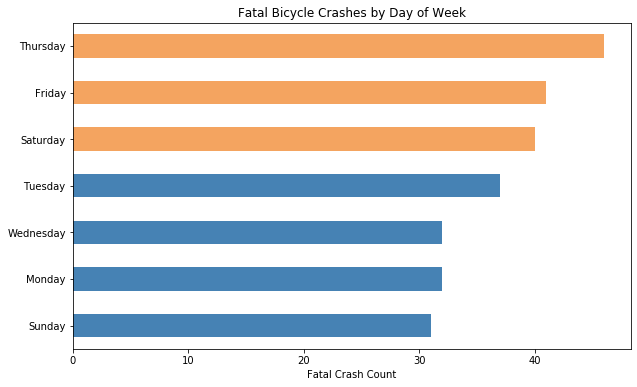

,Fatal Crash Count,Percent(%)
Day of Week,,
Wednesday,32,12.36
Tuesday,37,14.29
Saturday,40,15.44
Friday,41,15.83
Thursday,46,17.76


In [24]:
# Fatal Crash count grouped by Day of Week
total_killed_by_dayofweek = total_killed.groupby(["Day of Week"])["geo_point_2d"].count()
# biker_killed_by_dayofweek

total_killed_by_dayofweek_df = pd.DataFrame(total_killed_by_dayofweek)
total_killed_by_dayofweek_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)

mean_total_killed_by_dayofweek = round(total_killed_by_dayofweek_df["Fatal Crash Count"].mean(), 2)

total_killed_by_dayofweek_df["Percent(%)"] = ""

for row in range(len(total_killed_by_dayofweek_df)):
    total_killed_by_dayofweek_df["Percent(%)"] = round((total_killed_by_dayofweek_df["Fatal Crash Count"] / total_fatalities)*100, 2) 

total_killed_by_dayofweek_df = total_killed_by_dayofweek_df.sort_values(by="Fatal Crash Count", ascending=True)

# Create a bar plot for distribution of fatal crashes by day of week
colors = ['steelblue', 'steelblue', 'steelblue', 'steelblue', 'sandybrown', 'sandybrown', 'sandybrown']
ax = total_killed_by_dayofweek_df.plot(kind='barh', y = "Fatal Crash Count", color=colors, 
                                  figsize = (10,6), subplots = True, rot=0, legend=None)

plt.title("Fatal Bicycle Crashes by Day of Week")
plt.ylabel("")
plt.xlabel("Fatal Crash Count")

# Save the bar plot for distribution of fatal crashes by day of week
plt.savefig("Output/KilledDayofWeek.png")

# Display the bar plot for distribution of fatal crashes by day of week
plt.show()

total_killed_by_dayofweek_df.tail()

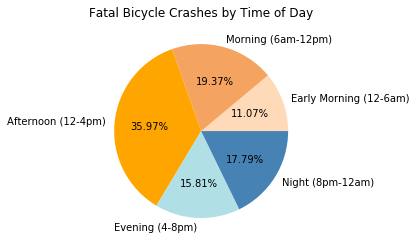

,Fatal Crash Count
Time of Day,
Afternoon (12-4pm),91
Morning (6am-12pm),49
Night (8pm-12am),45
Evening (4-8pm),40
Early Morning (12-6am),28


In [25]:
# Fatal Crash count grouped by Time of Day
total_killed_by_timeofday = total_killed.groupby(["Time of Day"])["geo_point_2d"].count()


total_killed_by_timeofday_df = pd.DataFrame(total_killed_by_timeofday)
total_killed_by_timeofday_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)

# Create a pie plot for fatal crashes by Time of Day
fig, ax1 = plt.subplots()
colors=('peachpuff', 'sandybrown', 'orange', 'powderblue', 'steelblue')
ax1 = total_killed_by_timeofday_df["Fatal Crash Count"].plot(kind='pie', colors=colors, autopct = "%.2f%%", figsize = (40,40), subplots=True)
plt.title("Fatal Bicycle Crashes by Time of Day")
plt.axis("off") # remove the axis labels

# Save the pie plot for fatal crashes by Time of Day
plt.savefig("Output/KilledTimeofDay.png")

# Display the pie plot for fatal crashes by Time of Day
plt.show()

total_killed_by_timeofday_df.sort_values(by = "Fatal Crash Count", ascending=False)

Total Fatal Crashes in Top 5 County Hot Spots: 82


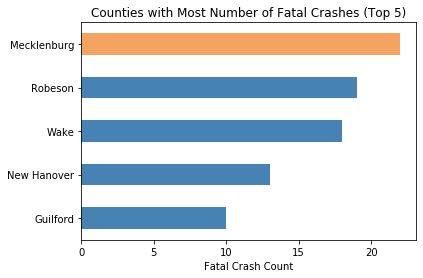

,Fatal Crash Count,Percent(%),Average/year
County,,,
Guilford,10,3.86,0.91
New Hanover,13,5.02,1.18
Wake,18,6.95,1.64
Robeson,19,7.34,1.73
Mecklenburg,22,8.49,2.00


In [26]:
# Fatal Crash count grouped by County
total_killed_by_county = total_killed.groupby(["County"])["geo_point_2d"].count()

total_killed_by_county_df = pd.DataFrame(total_killed_by_county)
total_killed_by_county_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_county_df = total_killed_by_county_df.sort_values(by = "Fatal Crash Count", ascending=False)

for row in range(len(total_killed_by_county_df)):
    total_killed_by_county_df["Percent(%)"] = round((total_killed_by_county_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    total_killed_by_county_df["Average/year"] = round((total_killed_by_county_df["Fatal Crash Count"] / 11), 2)

top5_total_killed_by_county_df = total_killed_by_county_df.sort_values(by = "Fatal Crash Count", ascending=True).tail()

top5sum=round(top5_total_killed_by_county_df["Fatal Crash Count"].sum(), 2)
print(f"Total Fatal Crashes in Top 5 County Hot Spots: {top5sum}")

# Create a pie plot for fatal crashes by county
fig, ax1 = plt.subplots()
colors = ['steelblue', 'steelblue', 'steelblue', 'steelblue', 'sandybrown']
ax1 = top5_total_killed_by_county_df["Fatal Crash Count"].plot(kind='barh', figsize = (60,40), subplots=True, color=colors)

plt.title("Counties with Most Number of Fatal Crashes (Top 5)")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by county
plt.savefig("Output/KilledbyCountyTop5.png")

# Display the pie plot for fatal crashes by county
plt.show()

top5_total_killed_by_county_df.tail(10)

C:\Users\waghr\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Total Fatal Crashes in Top 5 City Hot Spots: 52


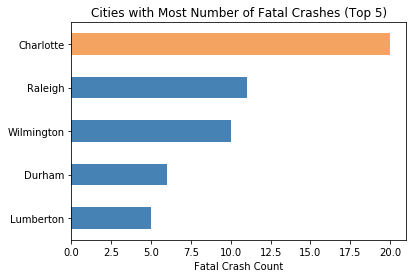

,Fatal Crash Count,Percent(%),Average/year
City,,,
Lumberton,5,1.93,0.45
Durham,6,2.32,0.55
Wilmington,10,3.86,0.91
Raleigh,11,4.25,1.00
Charlotte,20,7.72,1.82


In [27]:
# Fatal Crash count grouped by City
total_killed_by_city = total_killed.groupby(["City"])["geo_point_2d"].count()


total_killed_by_city_df = pd.DataFrame(total_killed_by_city)
total_killed_by_city_df.reset_index(inplace=True)

total_killed_by_city_clean_df = total_killed_by_city_df.loc[(total_killed_by_city_df['City'] != 'None - Rural Crash'),:]
total_killed_by_city_clean_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_city_clean_df = total_killed_by_city_clean_df.sort_values(by = "Fatal Crash Count", ascending=False)

for row in range(len(total_killed_by_city_df)):
    total_killed_by_city_clean_df["Percent(%)"] = round((total_killed_by_city_clean_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    total_killed_by_city_clean_df["Average/year"] = round((total_killed_by_city_clean_df["Fatal Crash Count"] / 11), 2)

top5_total_killed_by_city_clean_df = total_killed_by_city_clean_df.sort_values(by = "Fatal Crash Count", ascending=True).tail()
top5_total_killed_by_city_clean_df.set_index("City", inplace=True)

top5citysum=round(top5_total_killed_by_city_clean_df["Fatal Crash Count"].sum(), 2)
print(f"Total Fatal Crashes in Top 5 City Hot Spots: {top5citysum}")
top5_total_killed_by_city_clean_df.astype({"Fatal Crash Count": 'int64'})

# Create a pie plot for fatal crashes by city
fig, ax1 = plt.subplots()
colors = ['steelblue', 'steelblue', 'steelblue', 'steelblue', 'sandybrown']
ax1 = top5_total_killed_by_city_clean_df["Fatal Crash Count"].plot(kind='barh', figsize = (60,40), subplots=True, color=colors)

plt.title("Cities with Most Number of Fatal Crashes (Top 5)")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by city
plt.savefig("Output/KilledbyCityTop5.png")

# Display the pie plot for fatal crashes by city
plt.show()

top5_total_killed_by_city_clean_df.tail(10)

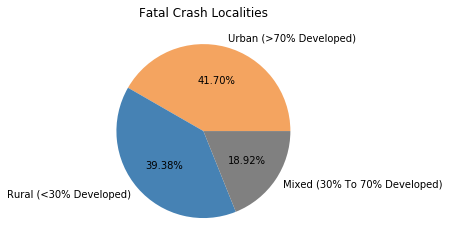

,Fatal Crash Count,Percent(%)
Locality,,
Urban (>70% Developed),108,41.70
Rural (<30% Developed),102,39.38
Mixed (30% To 70% Developed),49,18.92


In [28]:
# Fatal Crash count grouped by Locality
total_killed_by_locality = total_killed.groupby(["Locality"])["geo_point_2d"].count()

total_killed_by_locality_df = pd.DataFrame(total_killed_by_locality)
total_killed_by_locality_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_locality_df = total_killed_by_locality_df.sort_values(by = "Fatal Crash Count", ascending=False)

total_killed_by_locality = round(total_killed_by_locality_df["Fatal Crash Count"].sum(), 2)

total_killed_by_locality_df["Percent(%)"] = ""

for row in range(len(total_killed_by_locality_df)):
    total_killed_by_locality_df["Percent(%)"] = round((total_killed_by_locality_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Locality

fig, ax1 = plt.subplots()
colors=("sandybrown","steelblue","gray" )
ax1 = total_killed_by_locality_df["Fatal Crash Count"].plot(kind='pie', colors=colors,autopct = "%.2f%%", figsize = (60,40), subplots=True)
plt.title("Fatal Crash Localities")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Locality
plt.savefig("Output/KilledbyLocality.png")

# Display the pie plot for fatal crashes by Locality
plt.show()

total_killed_by_locality_df

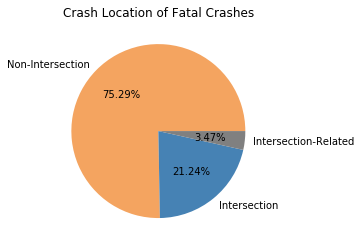

,Fatal Crash Count,Percent(%)
CrashLoc,,
Non-Intersection,195,75.29
Intersection,55,21.24
Intersection-Related,9,3.47


In [29]:
# Fatal Crash count grouped by Crash Location
total_killed_by_crashloc = total_killed.groupby(["CrashLoc"])["geo_point_2d"].count()

total_killed_by_crashloc_df = pd.DataFrame(total_killed_by_crashloc)
total_killed_by_crashloc_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_crashloc_df = total_killed_by_crashloc_df.sort_values(by = "Fatal Crash Count", ascending=False)

total_biker_killed_by_crashloc = round(total_killed_by_crashloc_df["Fatal Crash Count"].sum(), 2)

for row in range(len(total_killed_by_crashloc_df)):
    total_killed_by_crashloc_df["Percent(%)"] = round((total_killed_by_crashloc_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Crash Location
fig, ax1 = plt.subplots()
colors = ("sandybrown","steelblue","gray")
ax1 = total_killed_by_crashloc_df["Fatal Crash Count"].plot(kind='pie', colors=colors, autopct = "%.2f%%", figsize = (60,40), subplots=True)
plt.title("Crash Location of Fatal Crashes")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Crash Location
plt.savefig("Output/KilledbyBikePosition.png")

# Display the pie plot for fatal crashes by Crash Location
plt.show()

total_killed_by_crashloc_df

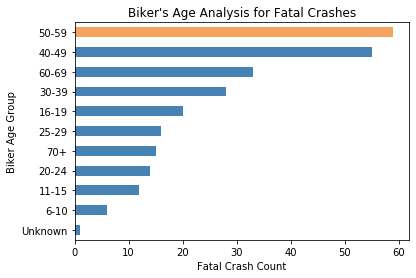

,Fatal Crash Count,Percent(%)
BikeAgeGrp,,
Unknown,1,0.39
6-10,6,2.32
11-15,12,4.63
20-24,14,5.41
70+,15,5.79
25-29,16,6.18
16-19,20,7.72
30-39,28,10.81
60-69,33,12.74


In [30]:
# Fatal Crash count grouped by Bikers Age group
total_killed_by_agegroup = total_killed.groupby(["BikeAgeGrp"])["geo_point_2d"].count()


total_killed_by_agegroup_df = pd.DataFrame(total_killed_by_agegroup)
total_killed_by_agegroup_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_agegroup_df = total_killed_by_agegroup_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_agegroup_df)):
    total_killed_by_agegroup_df["Percent(%)"] = round((total_killed_by_agegroup_df["Fatal Crash Count"] / total_fatalities)*100, 2) 

# Create a pie plot for fatal crashes by Bikers Age group
fig, ax1 = plt.subplots()
colors=("steelblue","steelblue", "steelblue", "steelblue","steelblue","steelblue","steelblue","steelblue","steelblue","steelblue","sandybrown")
ax1 = total_killed_by_agegroup_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (40,40), subplots=True)
plt.title("Biker's Age Analysis for Fatal Crashes")
plt.ylabel("Biker Age Group")
plt.xlabel("Fatal Crash Count")
# Save the pie plot for fatal crashes by Bikers Age group
plt.savefig("Output/KilledAgeAnalysis.png")

# Display the pie plot for fatal crashes by Bikers Age group
plt.show()

total_killed_by_agegroup_df

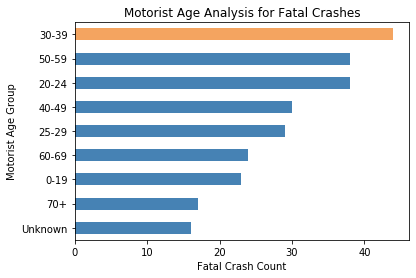

,Fatal Crash Count,Percent(%)
DrvrAgeGrp,,
Unknown,16,6.18
70+,17,6.56
0-19,23,8.88
60-69,24,9.27
25-29,29,11.20
40-49,30,11.58
20-24,38,14.67
50-59,38,14.67
30-39,44,16.99


In [31]:
# Fatal Crash count grouped by Motorist Age group
total_killed_by_motoristagegroup = total_killed.groupby(["DrvrAgeGrp"])["geo_point_2d"].count()


total_killed_by_motoristagegroup_df = pd.DataFrame(total_killed_by_motoristagegroup)
total_killed_by_motoristagegroup_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_motoristagegroup_df = total_killed_by_motoristagegroup_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_motoristagegroup_df)):
    total_killed_by_motoristagegroup_df["Percent(%)"] = round((total_killed_by_motoristagegroup_df["Fatal Crash Count"] / total_fatalities)*100, 2) 

# Create a pie plot for fatal crashes by Motorist Age group
fig, ax1 = plt.subplots()
colors=("steelblue","steelblue", "steelblue", "steelblue","steelblue","steelblue","steelblue","steelblue","sandybrown")
ax1 = total_killed_by_motoristagegroup_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (40,40), subplots=True)
plt.title("Motorist Age Analysis for Fatal Crashes")
plt.ylabel("Motorist Age Group")
plt.xlabel("Fatal Crash Count")
# Save the pie plot for fatal crashes by Motorist Age group
plt.savefig("Output/KilledMotoristAgeAnalysis.png")

# Display the pie plot for fatal crashes by Motorist Age group
plt.show()

total_killed_by_motoristagegroup_df

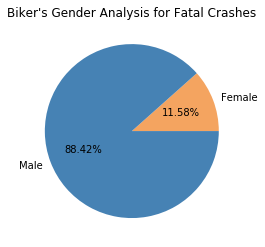

,Fatal Crash Count
BikeSex,
Male,229
Female,30


In [32]:
# Fatal Crash count grouped by Bikers Gender
total_killed_by_bikergender = total_killed.groupby(["BikeSex"])["geo_point_2d"].count()

total_killed_by_bikergender_df = pd.DataFrame(total_killed_by_bikergender)
total_killed_by_bikergender_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)

# Create a pie plot for fatal crashes by Bikers gender
fig, ax1 = plt.subplots()
colors = ("sandybrown", "steelblue")
ax1 = total_killed_by_bikergender_df["Fatal Crash Count"].plot(kind='pie', colors=colors, autopct = "%.2f%%", figsize = (40,40), subplots=True)
plt.title("Biker's Gender Analysis for Fatal Crashes")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Bikers gender
plt.savefig("Output/KilledBikerGenderAnalysis.png")

# Display the pie plot for fatal crashes by Bikers gender
plt.show()

total_killed_by_bikergender_df.sort_values(by = "Fatal Crash Count", ascending=False)

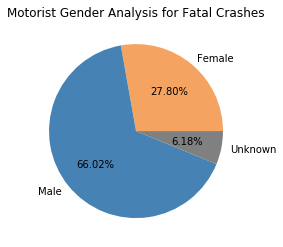

,Fatal Crash Count
DrvrSex,
Male,171
Female,72
Unknown,16


In [33]:
# Fatal Crash count grouped by Motorist Gender
total_killed_by_motoristgender = total_killed.groupby(["DrvrSex"])["geo_point_2d"].count()

total_killed_by_motoristgender_df = pd.DataFrame(total_killed_by_motoristgender)
total_killed_by_motoristgender_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)

# Create a pie plot for fatal crashes by Motorist gender
fig, ax1 = plt.subplots()
colors = ("sandybrown","steelblue", "gray")
ax1 = total_killed_by_motoristgender_df["Fatal Crash Count"].plot(kind='pie', colors=colors, autopct = "%.2f%%", figsize = (40,40), subplots=True)
plt.title("Motorist Gender Analysis for Fatal Crashes")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Motorist gender
plt.savefig("Output/KilledMotoristGenderAnalysis.png")

# Display the pie plot for fatal crashes by Motorist gender
plt.show()

total_killed_by_motoristgender_df.sort_values(by = "Fatal Crash Count", ascending=False)

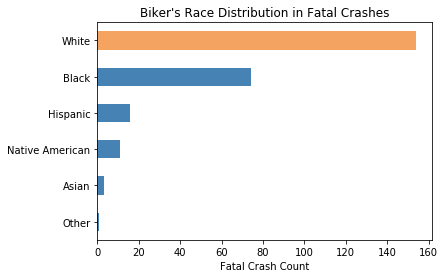

,Fatal Crash Count,Percent(%)
BikeRace,,
Other,1,0.39
Asian,3,1.16
Native American,11,4.25
Hispanic,16,6.18
Black,74,28.57
White,154,59.46


In [34]:
# Fatal Crash count grouped by Biker Race
total_killed_by_bikerrace = total_killed.groupby(["BikeRace"])["geo_point_2d"].count()

total_killed_by_bikerrace_df = pd.DataFrame(total_killed_by_bikerrace)
total_killed_by_bikerrace_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_bikerrace_df = total_killed_by_bikerrace_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_bikerrace_df)):
    total_killed_by_bikerrace_df["Percent(%)"] = round((total_killed_by_bikerrace_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Biker Race
fig, ax1 = plt.subplots()
colors=("steelblue","steelblue","steelblue","steelblue","steelblue","sandybrown")
ax1 = total_killed_by_bikerrace_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (60,40), subplots=True)
plt.title("Biker's Race Distribution in Fatal Crashes")
plt.ylabel("")
plt.xlabel("Fatal Crash Count")

# Save the pie plot for fatal crashes by Biker Race
plt.savefig("Output/KilledbyBikerRace.png")

# Display the pie plot for fatal crashes by Biker Race
plt.show()

total_killed_by_bikerrace_df

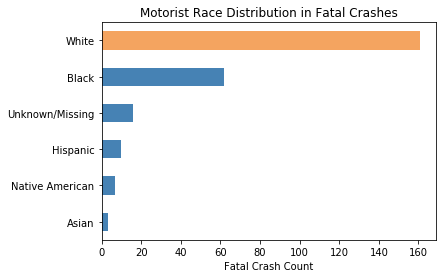

,Fatal Crash Count,Percent(%)
DrvrRace,,
Asian,3,1.16
Native American,7,2.70
Hispanic,10,3.86
Unknown/Missing,16,6.18
Black,62,23.94
White,161,62.16


In [35]:
# Fatal Crash count grouped by Motorist Race
total_killed_by_motoristrace = total_killed.groupby(["DrvrRace"])["geo_point_2d"].count()

total_killed_by_motoristrace_df = pd.DataFrame(total_killed_by_motoristrace)
total_killed_by_motoristrace_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_motoristrace_df = total_killed_by_motoristrace_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_motoristrace_df)):
    total_killed_by_motoristrace_df["Percent(%)"] = round((total_killed_by_motoristrace_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Motorist Race
fig, ax1 = plt.subplots()
colors=("steelblue","steelblue","steelblue","steelblue","steelblue","sandybrown")
ax1 = total_killed_by_motoristrace_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (60,40), subplots=True)
plt.title("Motorist Race Distribution in Fatal Crashes")
plt.ylabel("")
plt.xlabel("Fatal Crash Count")

# Save the pie plot for fatal crashes by Motorist Race
plt.savefig("Output/KilledbyMotoristRace.png")

# Display the pie plot for fatal crashes by Motorist Race
plt.show()

total_killed_by_motoristrace_df

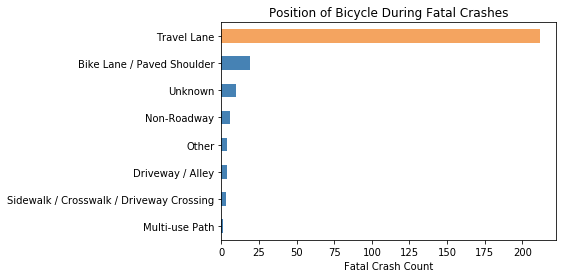

,Fatal Crash Count,Percent(%)
BikePos,,
Multi-use Path,1,0.39
Sidewalk / Crosswalk / Driveway Crossing,3,1.16
Driveway / Alley,4,1.54
Other,4,1.54
Non-Roadway,6,2.32
Unknown,10,3.86
Bike Lane / Paved Shoulder,19,7.34
Travel Lane,212,81.85


In [36]:
# Fatal Crash count grouped by Bike Position
total_killed_by_bikepos = total_killed.groupby(["BikePos"])["geo_point_2d"].count()

total_killed_by_bikepos_df = pd.DataFrame(total_killed_by_bikepos)
total_killed_by_bikepos_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_bikepos_df = total_killed_by_bikepos_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_bikepos_df)):
    total_killed_by_bikepos_df["Percent(%)"] = round((total_killed_by_bikepos_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Bike Position
fig, ax1 = plt.subplots()
colors=("steelblue","steelblue","steelblue","steelblue","steelblue","steelblue","steelblue","sandybrown")
ax1 = total_killed_by_bikepos_df["Fatal Crash Count"].plot(kind='barh', color=colors, figsize = (60,40), subplots=True)
plt.title("Position of Bicycle During Fatal Crashes")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by Bike Position
plt.savefig("Output/KilledbyBikePosition.png")

# Display the pie plot for fatal crashes by Bike Position
plt.show()

total_killed_by_bikepos_df

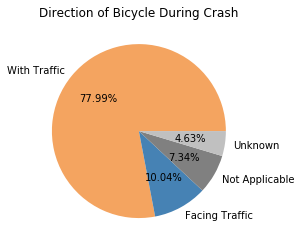

,Fatal Crash Count,Percent(%)
BikeDir,,
With Traffic,202,77.99
Facing Traffic,26,10.04
Not Applicable,19,7.34
Unknown,12,4.63


In [37]:
# Fatal Crash count grouped by Biker Direction
total_killed_by_bikedir = total_killed.groupby(["BikeDir"])["geo_point_2d"].count()

total_killed_by_bikedir_df = pd.DataFrame(total_killed_by_bikedir)
total_killed_by_bikedir_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_bikedir_df = total_killed_by_bikedir_df.sort_values(by = "Fatal Crash Count", ascending=False)

for row in range(len(total_killed_by_bikedir_df)):
    total_killed_by_bikedir_df["Percent(%)"] = round((total_killed_by_bikedir_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Intoxication
fig, ax1 = plt.subplots()
colors = ("sandybrown", "steelblue", "gray", "silver")
ax1 = total_killed_by_bikedir_df["Fatal Crash Count"].plot(kind='pie', colors=colors, autopct = "%.2f%%", figsize = (60,40), subplots=True)
plt.title("Direction of Bicycle During Crash")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Intoxication
plt.savefig("Output/KilledbyBikeDirection.png")

# Display the pie plot for fatal crashes by Intoxication
plt.show()

total_killed_by_bikedir_df

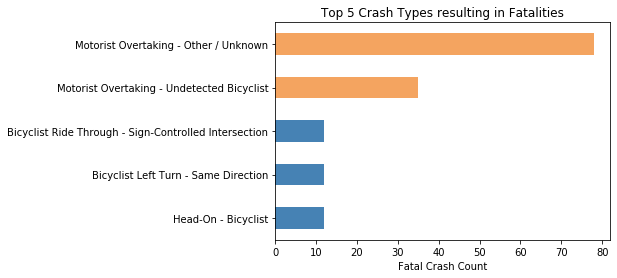

,Fatal Crash Count,Percent(%)
CrashType,,
Head-On - Bicyclist,12,4.63
Bicyclist Left Turn - Same Direction,12,4.63
Bicyclist Ride Through - Sign-Controlled Intersection,12,4.63
Motorist Overtaking - Undetected Bicyclist,35,13.51
Motorist Overtaking - Other / Unknown,78,30.12


In [38]:
# Fatal Crash count grouped by Crash Type
total_killed_by_crashtype = total_killed.groupby(["CrashType"])["geo_point_2d"].count()

total_killed_by_crashtype_df = pd.DataFrame(total_killed_by_crashtype)
total_killed_by_crashtype_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_crashtype_df = total_killed_by_crashtype_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_crashtype_df)):
    total_killed_by_crashtype_df["Percent(%)"] = round((total_killed_by_crashtype_df["Fatal Crash Count"] / total_fatalities)*100, 2) 

top5_total_killed_by_crashtype_df = total_killed_by_crashtype_df.tail()

# Create a pie plot for fatal crashes by Crash Type
fig, ax1 = plt.subplots()
colors=("steelblue","steelblue","steelblue","sandybrown","sandybrown")
ax1 = top5_total_killed_by_crashtype_df["Fatal Crash Count"].plot(kind='barh', color=colors, figsize = (40,40), subplots=True)
plt.title("Top 5 Crash Types resulting in Fatalities")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")
# Save the pie plot for fatal crashes by Crash Type
plt.savefig("Output/KilledbyCrashTypeTop5.png")

# Display the pie plot for fatal crashes by Crash Type
plt.show()

top5_total_killed_by_crashtype_df

# Update the below

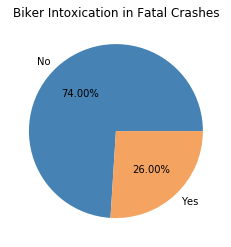

,Fatal Crash Count,Percent(%)
Biker Intox.,,
No,185,71.43
Yes,65,25.10


In [49]:
# Fatal Crash count grouped by Biker Intoxication
total_killed_by_bikerintox = biker_killed.groupby(["Biker Intox."])["geo_point_2d"].count()

total_killed_by_bikerintox_df = pd.DataFrame(total_killed_by_bikerintox)
total_killed_by_bikerintox_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_bikerintox_df = total_killed_by_bikerintox_df.sort_values(by = "Fatal Crash Count", ascending=False)

for row in range(len(total_killed_by_bikerintox_df)):
    total_killed_by_bikerintox_df["Percent(%)"] = round((total_killed_by_bikerintox_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Intoxication

colors=("steelblue", "sandybrown", "steelblue",)
fig, ax1 = plt.subplots()
ax1 = total_killed_by_bikerintox_df["Fatal Crash Count"].plot(kind='pie', autopct = "%.2f%%",colors=colors, figsize = (60,40), subplots=True)
plt.title("Biker Intoxication in Fatal Crashes")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Intoxication
plt.savefig("Output/KilledbyBikerIntoxication.png")

# Display the pie plot for fatal crashes by Intoxication
plt.show()

total_killed_by_bikerintox_df#.sort_values(by = "Fatal Crash Count", ascending=False)

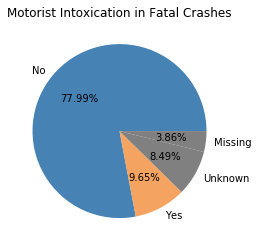

,Fatal Crash Count,Percent(%)
DrvrAlcFlg,,
No,202,77.99
Yes,25,9.65
Unknown,22,8.49
Missing,10,3.86


In [40]:
# Fatal Crash count grouped by Drivers Intoxication
total_killed_by_motoristintox = total_killed.groupby(["DrvrAlcFlg"])["geo_point_2d"].count()

total_killed_by_motoristintox_df = pd.DataFrame(total_killed_by_motoristintox)
total_killed_by_motoristintox_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)

total_killed_by_motoristintox_df = total_killed_by_motoristintox_df.sort_values(by = "Fatal Crash Count", ascending=False)

for row in range(len(total_killed_by_motoristintox_df)):
    total_killed_by_motoristintox_df["Percent(%)"] = round((total_killed_by_motoristintox_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Drivers Intoxication
fig, ax1 = plt.subplots()
colors = ("steelblue", "sandybrown", "gray", "grey")
ax1 = total_killed_by_motoristintox_df["Fatal Crash Count"].plot(kind='pie', colors=colors, autopct = "%.2f%%", figsize = (60,40), subplots=True)
plt.title("Motorist Intoxication in Fatal Crashes")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Drivers Intoxication
plt.savefig("Output/KilledbyMotoristIntoxication.png")

# Display the pie plot for fatal crashes by Intoxication
plt.show()

total_killed_by_motoristintox_df

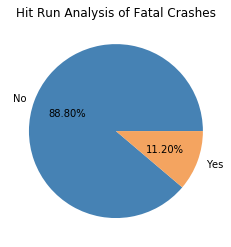

,Fatal Crash Count,Percent(%)
HitRun,,
No,230,88.8
Yes,29,11.2


In [41]:
# Fatal Crash count grouped by HitnRun
total_killed_by_HitRun = total_killed.groupby(["HitRun"])["geo_point_2d"].count()


total_killed_by_HitRun_df = pd.DataFrame(total_killed_by_HitRun)
total_killed_by_HitRun_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_HitRun_df = total_killed_by_HitRun_df.sort_values(by = "Fatal Crash Count", ascending=False)

for row in range(len(total_killed_by_HitRun_df)):
    total_killed_by_HitRun_df["Percent(%)"] = round((total_killed_by_HitRun_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by HitRun
fig, ax1 = plt.subplots()
colors = ("steelblue", "sandybrown")
ax1 = total_killed_by_HitRun_df["Fatal Crash Count"].plot(kind='pie', colors=colors, autopct = "%.2f%%", figsize = (40,40), subplots=True)
plt.title("Hit Run Analysis of Fatal Crashes")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by HitRun
plt.savefig("Output/KilledbyHitRun.png")

# Display the pie plot for fatal crashes by HitRun
plt.show()

total_killed_by_HitRun_df

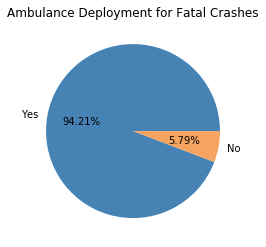

,Fatal Crash Count,Percent(%)
Ambulance,,
Yes,244,94.21
No,15,5.79


In [42]:
# Fatal Crash count grouped by Ambulance
total_killed_by_amb = total_killed.groupby(["Ambulance"])["geo_point_2d"].count()

total_killed_by_amb_df = pd.DataFrame(total_killed_by_amb)
total_killed_by_amb_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_amb_df = total_killed_by_amb_df.sort_values(by = "Fatal Crash Count", ascending=False)

for row in range(len(total_killed_by_amb_df)):
    total_killed_by_amb_df["Percent(%)"] = round((total_killed_by_amb_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Ambulance
fig, ax1 = plt.subplots()
colors = ("steelblue", "sandybrown")
ax1 = total_killed_by_amb_df["Fatal Crash Count"].plot(kind='pie', colors=colors, autopct = "%.2f%%", figsize = (60,40), subplots=True)
plt.title("Ambulance Deployment for Fatal Crashes")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Ambulance
plt.savefig("Output/KilledbyAmbulance.png")

# Display the pie plot for fatal crashes by Ambulance
plt.show()

total_killed_by_amb_df

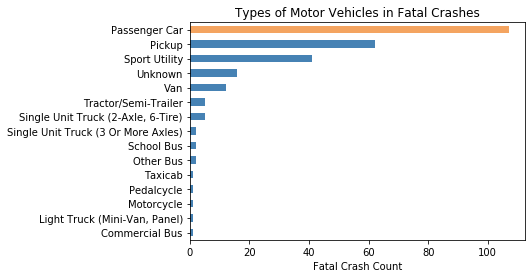

,Fatal Crash Count,Percent(%)
DrvrVehTyp,,
Commercial Bus,1,0.39
"Light Truck (Mini-Van, Panel)",1,0.39
Motorcycle,1,0.39
Pedalcycle,1,0.39
Taxicab,1,0.39
Other Bus,2,0.77
School Bus,2,0.77
Single Unit Truck (3 Or More Axles),2,0.77
"Single Unit Truck (2-Axle, 6-Tire)",5,1.93


In [63]:
# Fatal Crash count grouped by type of Motor Vehicle 
total_killed_by_vehtype = total_killed.groupby(["DrvrVehTyp"])["geo_point_2d"].count()

total_killed_by_vehtype_df = pd.DataFrame(total_killed_by_vehtype)
total_killed_by_vehtype_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_vehtype_df = total_killed_by_vehtype_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_vehtype_df)):
    total_killed_by_vehtype_df["Percent(%)"] = round((total_killed_by_vehtype_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by type of Motor Vehicle
fig, ax1 = plt.subplots()
colors=("steelblue","steelblue","steelblue","steelblue","steelblue","steelblue",
        "steelblue","steelblue","steelblue","steelblue","steelblue","steelblue","steelblue","steelblue","sandybrown")
ax1 = total_killed_by_vehtype_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (60,40), subplots=True)
plt.title("Types of Motor Vehicles in Fatal Crashes")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by type of Motor Vehicle
plt.savefig("Output/KilledbyMotorvehicletype.png")

# Display the pie plot for fatal crashes by type of Motor Vehicle
plt.show()

total_killed_by_vehtype_df

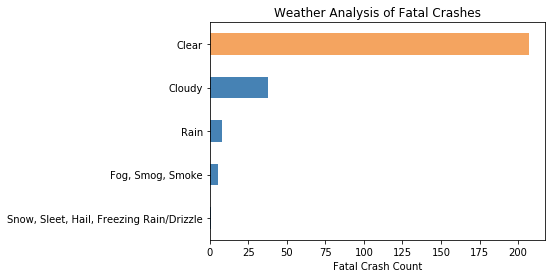

,Fatal Crash Count,Percent(%)
Weather,,
"Snow, Sleet, Hail, Freezing Rain/Drizzle",1,0.39
"Fog, Smog, Smoke",5,1.93
Rain,8,3.09
Cloudy,38,14.67
Clear,207,79.92


In [70]:
# Fatal Crash count grouped by Weather Condition 
total_killed_by_weather = total_killed.groupby(["Weather"])["geo_point_2d"].count()

total_killed_by_weather_df = pd.DataFrame(total_killed_by_weather)
total_killed_by_weather_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_weather_df = total_killed_by_weather_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_weather_df)):
    total_killed_by_weather_df["Percent(%)"] = round((total_killed_by_weather_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Weather Condition
fig, ax1 = plt.subplots()
colors=("steelblue","steelblue","steelblue","steelblue","sandybrown")
ax1 = total_killed_by_weather_df["Fatal Crash Count"].plot(kind='barh',color = colors, figsize = (60,40), subplots=True)
plt.title("Weather Analysis of Fatal Crashes")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by Weather Condition
plt.savefig("Output/KilledbyWeatherCondition.png")

# Display the pie plot for fatal crashes by Weather Condition
plt.show()

total_killed_by_weather_df

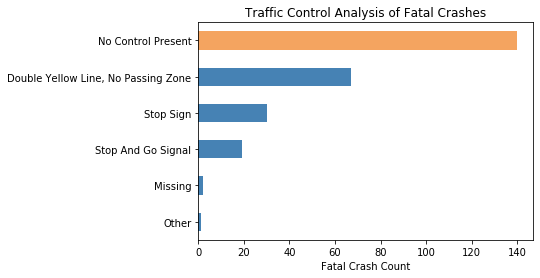

,Fatal Crash Count,Percent(%)
TraffCntrl,,
Other,1,0.39
Missing,2,0.77
Stop And Go Signal,19,7.34
Stop Sign,30,11.58
"Double Yellow Line, No Passing Zone",67,25.87
No Control Present,140,54.05


In [73]:
# Fatal Crash count grouped by Traffic Control 
total_killed_by_trafficcontrol = total_killed.groupby(["TraffCntrl"])["geo_point_2d"].count()

total_killed_by_trafficcontrol_df = pd.DataFrame(total_killed_by_trafficcontrol)
total_killed_by_trafficcontrol_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_trafficcontrol_df = total_killed_by_trafficcontrol_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_trafficcontrol_df)):
    total_killed_by_trafficcontrol_df["Percent(%)"] = round((total_killed_by_trafficcontrol_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Traffic Control
fig, ax1 = plt.subplots()
colors = ("steelblue","steelblue","steelblue","steelblue","steelblue","sandybrown")
ax1 = total_killed_by_trafficcontrol_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (60,40), subplots=True)
plt.title("Traffic Control Analysis of Fatal Crashes")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by Traffic Control
plt.savefig("Output/KilledbyTrafficControl.png")

# Display the pie plot for fatal crashes by Traffic Control
plt.show()

total_killed_by_trafficcontrol_df

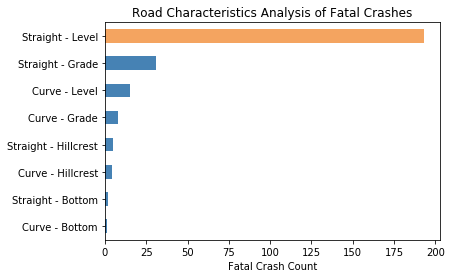

,Fatal Crash Count,Percent(%)
RdCharacte,,
Curve - Bottom,1,0.39
Straight - Bottom,2,0.77
Curve - Hillcrest,4,1.54
Straight - Hillcrest,5,1.93
Curve - Grade,8,3.09
Curve - Level,15,5.79
Straight - Grade,31,11.97
Straight - Level,193,74.52


In [75]:
# Fatal Crash count grouped by Road Characteristics 
total_killed_by_roadchar = total_killed.groupby(["RdCharacte"])["geo_point_2d"].count()

total_killed_by_roadchar_df = pd.DataFrame(total_killed_by_roadchar)
total_killed_by_roadchar_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_roadchar_df = total_killed_by_roadchar_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_roadchar_df)):
    total_killed_by_roadchar_df["Percent(%)"] = round((total_killed_by_roadchar_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Road Characteristics 
fig, ax1 = plt.subplots()
colors = ("steelblue","steelblue", "steelblue","steelblue","steelblue","steelblue","steelblue","sandybrown")
ax1 = total_killed_by_roadchar_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (60,40), subplots=True)
plt.title("Road Characteristics Analysis of Fatal Crashes")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by Road Characteristics 
plt.savefig("Output/KilledbyRoadChar.png")

# Display the pie plot for fatal crashes by Road Characteristics 
plt.show()

total_killed_by_roadchar_df

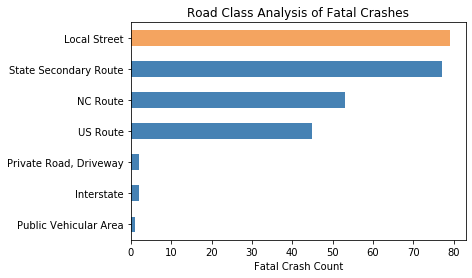

,Fatal Crash Count,Percent(%)
RdClass,,
Public Vehicular Area,1,0.39
Interstate,2,0.77
"Private Road, Driveway",2,0.77
US Route,45,17.37
NC Route,53,20.46
State Secondary Route,77,29.73
Local Street,79,30.50


In [78]:
# Fatal Crash count grouped by Road Class 
total_killed_by_roadclass = total_killed.groupby(["RdClass"])["geo_point_2d"].count()

total_killed_by_roadclass_df = pd.DataFrame(total_killed_by_roadclass)
total_killed_by_roadclass_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_roadclass_df = total_killed_by_roadclass_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_roadclass_df)):
    total_killed_by_roadclass_df["Percent(%)"] = round((total_killed_by_roadclass_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Road Class 
fig, ax1 = plt.subplots()
colors = ("steelblue","steelblue", "steelblue","steelblue","steelblue","steelblue","sandybrown")
ax1 = total_killed_by_roadclass_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (60,40), subplots=True)
plt.title("Road Class Analysis of Fatal Crashes")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by Road Class 
plt.savefig("Output/KilledbyRoadClass.png")

# Display the pie plot for fatal crashes by Road Class 
plt.show()

total_killed_by_roadclass_df

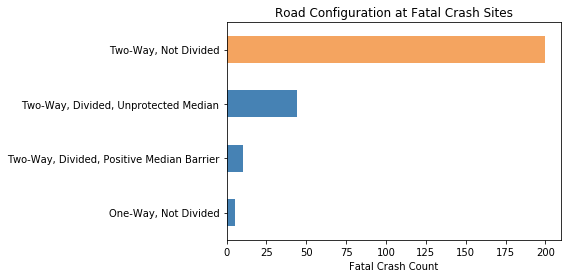

,Fatal Crash Count,Percent(%)
RdConfig,,
"One-Way, Not Divided",5,1.93
"Two-Way, Divided, Positive Median Barrier",10,3.86
"Two-Way, Divided, Unprotected Median",44,16.99
"Two-Way, Not Divided",200,77.22


In [84]:
# Fatal Crash count grouped by Road Config 
total_killed_by_roadconfig = total_killed.groupby(["RdConfig"])["geo_point_2d"].count()

total_killed_by_roadconfig_df = pd.DataFrame(total_killed_by_roadconfig)
total_killed_by_roadconfig_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_roadconfig_df = total_killed_by_roadconfig_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_roadconfig_df)):
    total_killed_by_roadconfig_df["Percent(%)"] = round((total_killed_by_roadconfig_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Road Config 
fig, ax1 = plt.subplots()
colors = ("steelblue","steelblue", "steelblue","sandybrown", "steelblue","steelblue","steelblue")
ax1 = total_killed_by_roadconfig_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (60,40), subplots=True)
plt.title("Road Configuration at Fatal Crash Sites")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by Road Config 
plt.savefig("Output/KilledbyRoadConfig.png")

# Display the pie plot for fatal crashes by Road Config 
plt.show()

total_killed_by_roadconfig_df


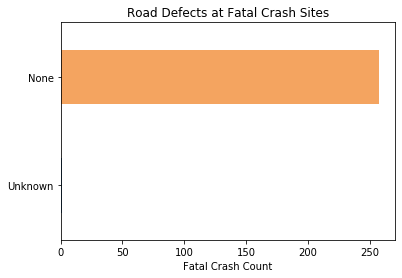

,Fatal Crash Count,Percent(%)
RdDefects,,
Unknown,1,0.39
None,258,99.61


In [86]:
# Fatal Crash count grouped by Road Defects 
total_killed_by_roaddefects = total_killed.groupby(["RdDefects"])["geo_point_2d"].count()

total_killed_by_roaddefects_df = pd.DataFrame(total_killed_by_roaddefects)
total_killed_by_roaddefects_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_roaddefects_df = total_killed_by_roaddefects_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_roaddefects_df)):
    total_killed_by_roaddefects_df["Percent(%)"] = round((total_killed_by_roaddefects_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Road Defects
fig, ax1 = plt.subplots()
colors = ("steelblue","sandybrown")
ax1 = total_killed_by_roaddefects_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (60,40), subplots=True)
plt.title("Road Defects at Fatal Crash Sites")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by Road Defects
plt.savefig("Output/KilledbyRoadDefects.png")

# Display the pie plot for fatal crashes by Road Defects 
plt.show()

total_killed_by_roaddefects_df

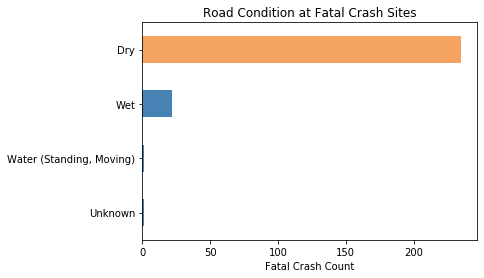

,Fatal Crash Count,Percent(%)
RdConditio,,
Unknown,1,0.39
"Water (Standing, Moving)",1,0.39
Wet,22,8.49
Dry,235,90.73


In [123]:
# Fatal Crash count grouped by Road Condition 
total_killed_by_roadcondition = total_killed.groupby(["RdConditio"])["geo_point_2d"].count()

total_killed_by_roadcondition_df = pd.DataFrame(total_killed_by_roadcondition)
total_killed_by_roadcondition_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_roadcondition_df = total_killed_by_roadcondition_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_roadcondition_df)):
    total_killed_by_roadcondition_df["Percent(%)"] = round((total_killed_by_roadcondition_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Road Condition 
fig, ax1 = plt.subplots()
colors = ('steelblue', 'steelblue', 'steelblue','sandybrown', 'steelblue' )
ax1 = total_killed_by_roadcondition_df["Fatal Crash Count"].plot(kind='barh',color = colors, figsize = (60,40), subplots=True)
plt.title("Road Condition at Fatal Crash Sites")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by Road Condition 
plt.savefig("Output/KilledbyRoadCondition.png")

# Display the pie plot for fatal crashes by Road Condition 
plt.show()

total_killed_by_roadcondition_df

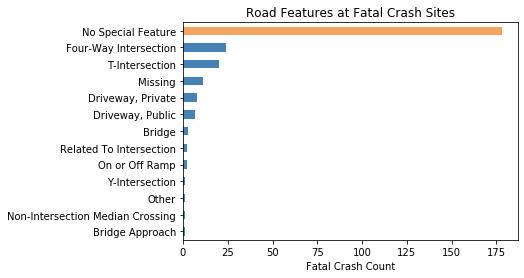

,Fatal Crash Count,Percent(%)
RdFeature,,
Bridge Approach,1,0.39
Non-Intersection Median Crossing,1,0.39
Other,1,0.39
Y-Intersection,1,0.39
On or Off Ramp,2,0.77
Related To Intersection,2,0.77
Bridge,3,1.16
"Driveway, Public",7,2.70
"Driveway, Private",8,3.09


In [89]:
# Fatal Crash count grouped by Road features
total_killed_by_roadfeatures = total_killed.groupby(["RdFeature"])["geo_point_2d"].count()

total_killed_by_roadfeatures_df = pd.DataFrame(total_killed_by_roadfeatures)
total_killed_by_roadfeatures_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_roadfeatures_df = total_killed_by_roadfeatures_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_roadfeatures_df)):
    total_killed_by_roadfeatures_df["Percent(%)"] = round((total_killed_by_roadfeatures_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Road features 
fig, ax1 = plt.subplots()
colors = ("steelblue","steelblue", "steelblue","steelblue","steelblue", "steelblue", "steelblue","steelblue","steelblue",
          "steelblue","steelblue", "steelblue","sandybrown")
ax1 = total_killed_by_roadfeatures_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (60,40), subplots=True)
plt.title("Road Features at Fatal Crash Sites")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by Road features 
plt.savefig("Output/KilledbyRoadFeatures.png")

# Display the pie plot for fatal crashes by Road features 
plt.show()

total_killed_by_roadfeatures_df

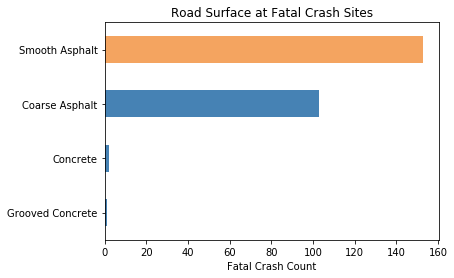

,Fatal Crash Count,Percent(%)
RdSurface,,
Grooved Concrete,1,0.39
Concrete,2,0.77
Coarse Asphalt,103,39.77
Smooth Asphalt,153,59.07


In [90]:

# Fatal Crash count grouped by Road Surface
total_killed_by_roadsurface = total_killed.groupby(["RdSurface"])["geo_point_2d"].count()

total_killed_by_roadsurface_df = pd.DataFrame(total_killed_by_roadsurface)
total_killed_by_roadsurface_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_roadsurface_df = total_killed_by_roadsurface_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_roadsurface_df)):
    total_killed_by_roadsurface_df["Percent(%)"] = round((total_killed_by_roadsurface_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Road Surface
fig, ax1 = plt.subplots()
colors = ("steelblue","steelblue", "steelblue","sandybrown", "steelblue","steelblue","steelblue")
ax1 = total_killed_by_roadsurface_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (60,40), subplots=True)
plt.title("Road Surface at Fatal Crash Sites")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by Road Surface
plt.savefig("Output/KilledbyRoadSurface.png")

# Display the pie plot for fatal crashes by Road Surface
plt.show()

total_killed_by_roadsurface_df

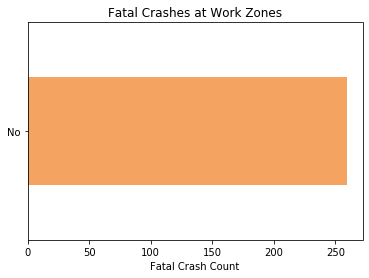

,Fatal Crash Count,Percent(%)
Workzone,,
No,259,100.0


In [92]:
# Fatal Crash count grouped by Workzone
total_killed_by_workzone = total_killed.groupby(["Workzone"])["geo_point_2d"].count()

total_killed_by_workzone_df = pd.DataFrame(total_killed_by_workzone)
total_killed_by_workzone_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_workzone_df = total_killed_by_workzone_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_workzone_df)):
    total_killed_by_workzone_df["Percent(%)"] = round((total_killed_by_workzone_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by Workzone
fig, ax1 = plt.subplots()
colors = ("sandybrown")
ax1 = total_killed_by_workzone_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (60,40), subplots=True)
plt.title("Fatal Crashes at Work Zones")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by Workzone 
plt.savefig("Output/KilledbyWorkzone.png")

# Display the pie plot for fatal crashes by Workzone 
plt.show()

total_killed_by_workzone_df

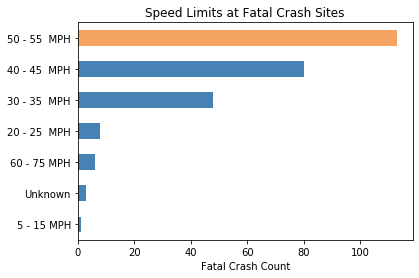

,Fatal Crash Count,Percent(%)
SpeedLimit,,
5 - 15 MPH,1,0.39
Unknown,3,1.16
60 - 75 MPH,6,2.32
20 - 25 MPH,8,3.09
30 - 35 MPH,48,18.53
40 - 45 MPH,80,30.89
50 - 55 MPH,113,43.63


In [96]:
# Fatal Crash count grouped by speedlimit
total_killed_by_speedlimit = total_killed.groupby(["SpeedLimit"])["geo_point_2d"].count()

total_killed_by_speedlimit_df = pd.DataFrame(total_killed_by_speedlimit)
total_killed_by_speedlimit_df.rename(columns = {"geo_point_2d": "Fatal Crash Count"}, inplace = True)
total_killed_by_speedlimit_df = total_killed_by_speedlimit_df.sort_values(by = "Fatal Crash Count", ascending=True)

for row in range(len(total_killed_by_speedlimit_df)):
    total_killed_by_speedlimit_df["Percent(%)"] = round((total_killed_by_speedlimit_df["Fatal Crash Count"] / total_fatalities)*100, 2) 
    
# Create a pie plot for fatal crashes by speedlimit
fig, ax1 = plt.subplots()
colors = ("steelblue","steelblue","steelblue","steelblue","steelblue", "steelblue","sandybrown")
ax1 = total_killed_by_speedlimit_df["Fatal Crash Count"].plot(kind='barh', color=colors,figsize = (60,40), subplots=True)
plt.title("Speed Limits at Fatal Crash Sites")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by speedlimit 
plt.savefig("Output/Killedbyspeedlimit.png")

# Display the pie plot for fatal crashes by speedlimit 
plt.show()

total_killed_by_speedlimit_df

In [104]:
top5_avg_biker_killed_by_county_df = biker_killed_by_county_df.sort_values(by = "Average Biker Fatalities", ascending=False)
top5_avg_biker_killed_by_county_df

,Bicyclist Fatal Crash Count,Percent(%),Average Biker Fatalities
County,,,
Mecklenburg,22,8.8,2.00
Wake,18,7.2,1.64
Robeson,17,6.8,1.55
New Hanover,13,5.2,1.18
Guilford,10,4.0,0.91
...,...,...,...
Wilkes,1,0.4,0.09
Stokes,1,0.4,0.09
Swain,1,0.4,0.09


## Bicycle Crash Hotspots in the State

In [175]:
from pprint import pprint

# Configure gmaps with API key
gmaps.configure(api_key=gkey)

crash_hotspots = crash_data.groupby(["City"]).agg({"City":"count"})
crash_hotspots.columns=["Crash Count"]
crash_hotspots.reset_index(inplace=True)

crash_hotspots["City Latitude"] = ""
crash_hotspots["City Longitude"] = ""

params = {"key": gkey}

for index, row in crash_hotspots.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    current_city = row["City"]
    state = "North Carolina"
    params["address"] = f"{current_city},{state}"
    jsonresponse = requests.get(base_url, params=params).json()
    #pprint(jsonresponse,indent =4)
    current_city_latitude = jsonresponse["results"][0]["geometry"]["location"]["lat"]
    current_city_longitude = jsonresponse["results"][0]["geometry"]["location"]["lng"]
    crash_hotspots.loc[index,"City Latitude"] = current_city_latitude
    crash_hotspots.loc[index,"City Longitude"] = current_city_longitude
    
crash_hotspots.head(60)

,City,Crash Count,City Latitude,City Longitude
0,Aberdeen,4,35.1315,-79.4295
1,Ahoskie,8,36.2868,-76.9847
2,Alamance,1,36.0351,-79.4859
3,Albemarle,16,35.3501,-80.2001
4,Alexander,1,35.6988,-82.6366
5,Alliance,2,35.1449,-76.8022
6,Andrews,4,35.2018,-83.8241
7,Angier,4,35.5071,-78.7392
8,Apex,38,35.7327,-78.8503
9,Arapahoe,1,35.0257,-76.8255


In [177]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

locations = crash_hotspots[["City Latitude", "City Longitude"]].astype(float)
crash_count = crash_hotspots["Crash Count"].astype(float)

# Create a Crash Count Heatmap layer for each city
fig5 = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=crash_count, 
                                 dissipating=False, max_intensity=1000,
                                 point_radius = 0.10)
fig5.add_layer(heat_layer)
fig5

Figure(layout=FigureLayout(height='420px'))

In [178]:
crash_rate = crash_hotspots["Crash Count"].tolist()

# Create bank symbol layer
crash_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
    info_box_content=[f"{City}" for City in crash_rate]
)
fig2 = gmaps.figure()
fig2.add_layer(crash_layer)

# Create a combined map
fig3 = gmaps.figure()
fig3.add_layer(heat_layer)
fig3.add_layer(crash_layer)
fig3

Figure(layout=FigureLayout(height='420px'))

In [31]:
killed = crash_data.loc[crash_data["CrashSevr"] == "K: Killed",:]
fatal_cities = killed.groupby("City")["geo_point_2d"].count()

#fatality_hotspots_by_county = killed.groupby("County")["geo_point_2d"].count()


fatal_cities_df = pd.DataFrame(fatal_cities)
fatal_cities_df.rename(columns={"geo_point_2d": "Fatal Crash Count"}, inplace = True)
fatal_cities_df = fatal_cities_df.sort_values(by=["Fatal Crash Count"], ascending=False)
fatal_cities_df.reset_index(inplace=True)


fatal_cities_df["City Latitude"] = ""
fatal_cities_df["City Longitude"] = ""

params = {"key": gkey}

for index, row in fatal_cities_df.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    current_city = row["City"]
    state = "North Carolina"
    params["address"] = f"{current_city},{state}"
    jsonresponse = requests.get(base_url, params=params).json()
    #pprint(jsonresponse,indent =4)
    current_city_latitude = jsonresponse["results"][0]["geometry"]["location"]["lat"]
    current_city_longitude = jsonresponse["results"][0]["geometry"]["location"]["lng"]
    fatal_cities_df.loc[index,"City Latitude"] = current_city_latitude
    fatal_cities_df.loc[index,"City Longitude"] = current_city_longitude
    
fatal_cities_df = fatal_cities_df.drop([0])
fatal_cities_df

,City,Fatal Crash Count,City Latitude,City Longitude
1,Charlotte,20,35.2271,-80.8431
2,Raleigh,11,35.7796,-78.6382
3,Wilmington,10,34.2104,-77.8868
4,Durham,6,35.994,-78.8986
5,Lumberton,5,34.6182,-79.0086
6,Fayetteville,4,35.0527,-78.8784
7,Jacksonville,4,34.7541,-77.4302
8,Greensboro,3,36.0726,-79.792
9,Asheville,3,35.5951,-82.5515
10,High Point,2,35.9557,-80.0053


In [32]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

locations = fatal_cities_df[["City Latitude", "City Longitude"]].astype(float)
fatal_crash_count = fatal_cities_df["Fatal Crash Count"].astype(float)

# Create a Crash Count Heatmap layer for each city
fig = gmaps.figure()
fatal_heat_layer = gmaps.heatmap_layer(locations, weights=fatal_crash_count, 
                                 dissipating=False, max_intensity=5,
                                 point_radius = 0.10)
fig.add_layer(fatal_heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [33]:
fatal_crash_rate = fatal_cities_df["Fatal Crash Count"].tolist()

# Create bank symbol layer
fatal_crash_layer = gmaps.symbol_layer(locations, scale = 1)
fig = gmaps.figure()
fig.add_layer(fatal_crash_layer)

In [35]:
# Create a combined map
fig = gmaps.figure()
fig.add_layer(fatal_heat_layer)
fig.add_layer(fatal_crash_layer)
fig


Figure(layout=FigureLayout(height='420px'))

In [40]:
crashes = crash_data[["geo_point_2d", "County", "City"]]
crashes_df = crashes.groupby(["County"])["geo_point_2d"].count()
crashes_df.sort_values(ascending=False)


County
Wake           1500
Mecklenburg    1421
New Hanover     767
Guilford        741
Durham          539
               ... 
Tyrrell           3
Clay              3
Alexander         3
Mitchell          2
Alleghany         1
Name: geo_point_2d, Length: 100, dtype: int64